In [206]:
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [207]:
# SQL Server (entorno local)
LOCAL_SERVER = 'localhost'
LOCAL_DATABASE = 'dwh_case1'
LOCAL_DRIVER = '{ODBC Driver 17 for SQL Server}'

# Construcción de cadena de conexión
local_conn_str = f"DRIVER={LOCAL_DRIVER};SERVER={LOCAL_SERVER};DATABASE={LOCAL_DATABASE};Trusted_Connection=yes;TrustServerCertificate=yes"
conn = pyodbc.connect(local_conn_str)

In [208]:
# Lectura del archivo SQL
with open("../data/dwh/features_pvp.sql", "r") as file:
    query = file.read()

# Ejecutar la consulta y cargarla en un DataFrame
import pandas as pd

# Suponiendo que ya tienes una conexión activa (por ejemplo `conn`)
df = pd.read_sql_query(query, conn)


In [209]:
df.isnull().sum() 

PVP                 0
avg_car_age         0
avg_km_revision     0
avg_revisiones      0
churn_percentage    0
dtype: int64

In [210]:
df.duplicated().sum() # Valores duplicados.

0

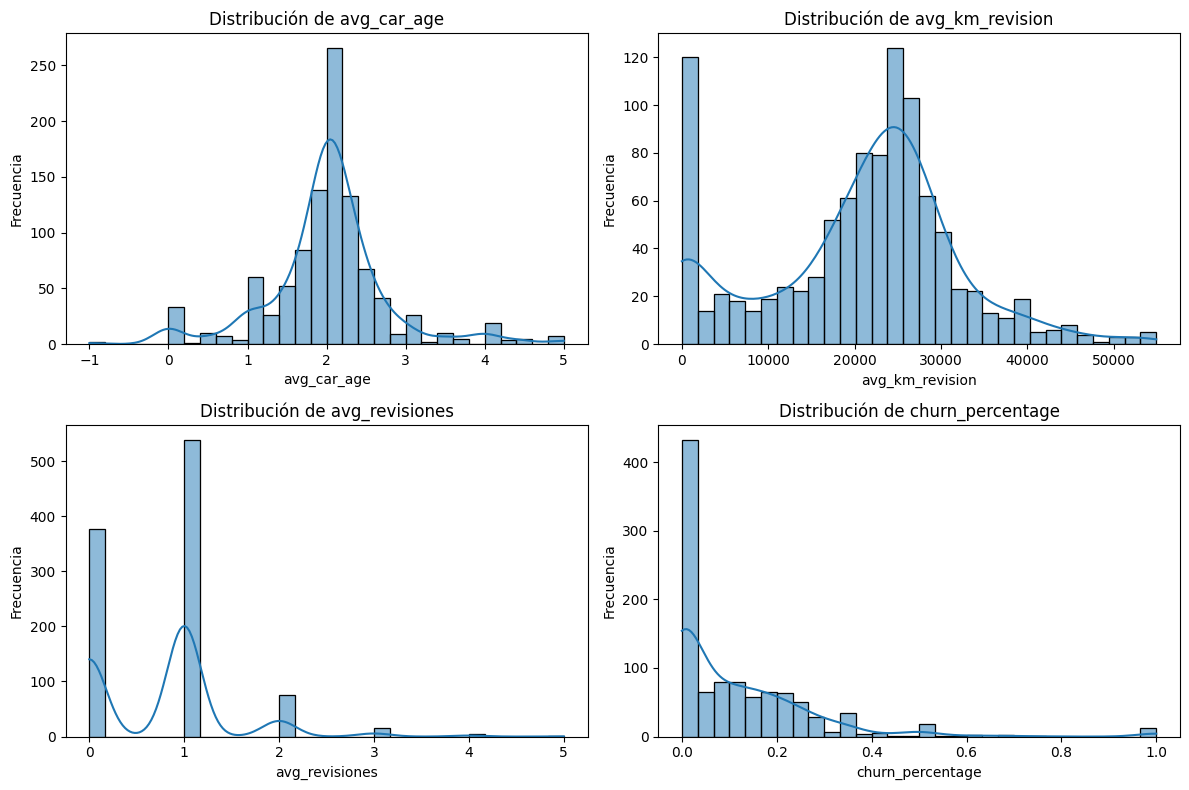

In [211]:
# Histograma de cada variable numérica.
variables = ['avg_car_age', 'avg_km_revision', 'avg_revisiones', 'churn_percentage']

plt.figure(figsize=(12, 8))
for i, col in enumerate(variables, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

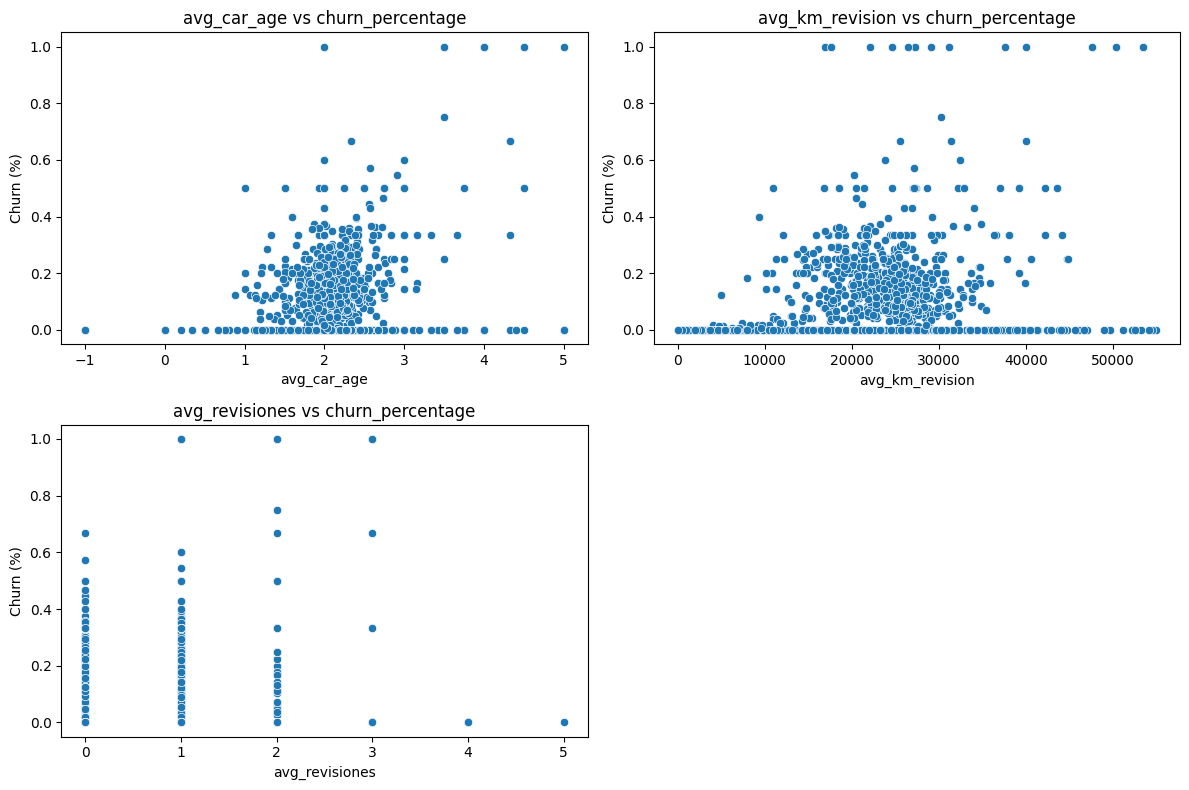

In [212]:
# Gráficos de dispersión para observar patrones lineales.
plt.figure(figsize=(12, 8))
for i, col in enumerate(['avg_car_age', 'avg_km_revision', 'avg_revisiones'], 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=df[col], y=df['churn_percentage'])
    plt.title(f'{col} vs churn_percentage')
    plt.xlabel(col)
    plt.ylabel('Churn (%)')
plt.tight_layout()
plt.show()

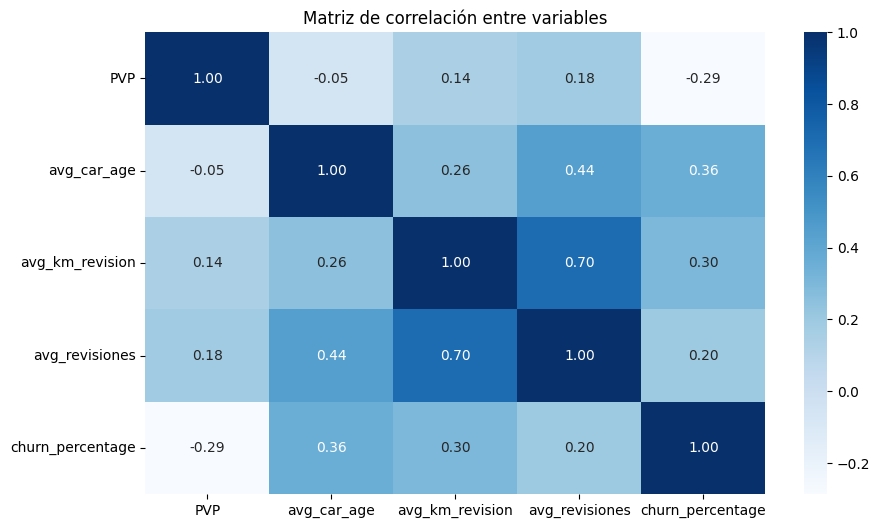

In [213]:
# Matriz de correlación.
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues', fmt=".2f")
plt.title("Matriz de correlación entre variables")
plt.show()

In [214]:
from sklearn.feature_selection import f_regression

X = df[['PVP', 'avg_car_age', 'avg_km_revision', 'avg_revisiones']]
y = df['churn_percentage']

f_values, p_values = f_regression(X, y)
pd.DataFrame({'Feature': X.columns, 'F-value': f_values, 'p-value': p_values})


,Feature,F-value,p-value
0,PVP,90.150410,1.541782e-20
1,avg_car_age,149.801061,3.250112e-32
2,avg_km_revision,100.335007,1.400962e-22
3,avg_revisiones,42.169689,1.311118e-10


In [215]:
# Definición de variables predictoras (X) y variable objetivo (y).
X = df[['PVP', 'avg_car_age', 'avg_km_revision', 'avg_revisiones']]
y = df['churn_percentage']

In [216]:
# Entrenamiento del modelo.
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [217]:
# Predicción del Churn.
y_pred = model.predict(X)
y_pred_clipped = np.clip(y_pred, 0, 1)

In [218]:
r2 = round(r2_score(y, y_pred_clipped), 2)
mse = round(mean_squared_error(y, y_pred_clipped), 3)

metrics_df = pd.DataFrame({
    'Métrica': ['R² (coef. de determinación)', 'MSE (error cuadrático medio)'],
    'Valor': [r2, mse]
})

print("Evaluación del modelo:")
display(metrics_df)


Evaluación del modelo:


,Métrica,Valor
0,R² (coef. de determinación),0.300
1,MSE (error cuadrático medio),0.018


In [219]:
coef_df = pd.DataFrame({
    'Variable': X.columns.tolist() + ['Intercepto'],
    'Coeficiente': model.coef_.tolist() + [model.intercept_]
})

print("Coeficientes estimados:")
display(coef_df)

Coeficientes estimados:


,Variable,Coeficiente
0,PVP,-0.000008
1,avg_car_age,0.065723
2,avg_km_revision,0.000005
3,avg_revisiones,-0.030640
4,Intercepto,0.099220


0	PVP	-0.000006
1	avg_car_age	0.200417
2	avg_km_revision	-0.000004
3	avg_revisiones	-0.136655
4	Intercepto	0.187785

In [220]:
cursor = conn.cursor()
table = "churn_coef"

# Creación de la tabla.
cursor.execute(f"""
IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='{table}' AND xtype='U')
CREATE TABLE {table} (
    Variable NVARCHAR(50) PRIMARY KEY,
    Coeficiente FLOAT
)
""")

# Vacio de la tabla antes de insertar nuevos coeficientes.
cursor.execute(f"DELETE FROM {table}")

# Inserción de coeficientes en la tabla.
insert_sql = f"INSERT INTO {table} (Variable, Coeficiente) VALUES (?, ?)"
for _, row in coef_df.iterrows():
    cursor.execute(insert_sql, row['Variable'], row['Coeficiente'])

conn.commit()
conn.close()
print(f"Tabla '{table}' creada y poblada correctamente.")

Tabla 'churn_coef' creada y poblada correctamente.


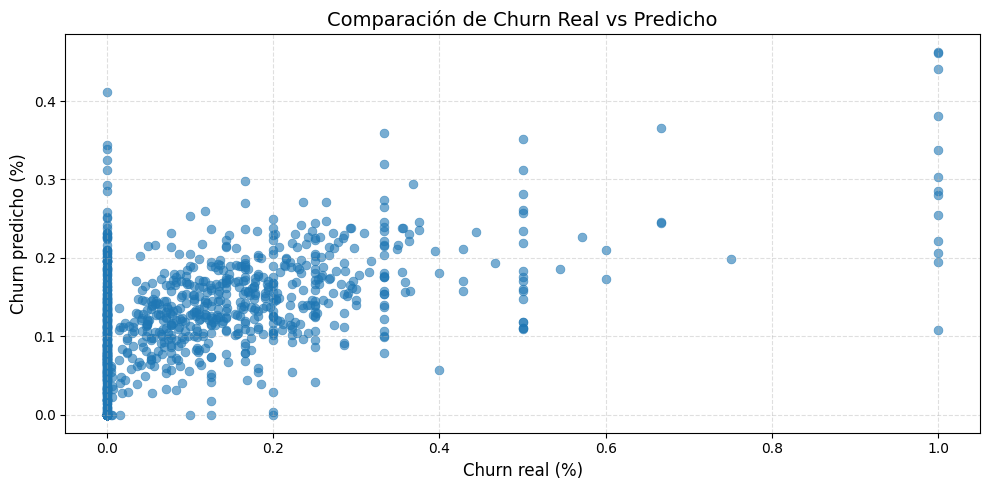

In [221]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y, y=y_pred_clipped, alpha=0.6, s=40, edgecolor=None)

plt.xlabel("Churn real (%)", fontsize=12)
plt.ylabel("Churn predicho (%)", fontsize=12)
plt.title("Comparación de Churn Real vs Predicho", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()